In [1]:
setwd(".../output")
library(ggrepel)


Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Loading required package: ggplot2



In [2]:
#1.perform corr for all genes per variable, check here also CLCN4

In [3]:
library(rrvgo)
library(gprofiler2)
library(dplyr)
library(stringr)
library(org.Hs.eg.db) 
library(AnnotationDbi)
library(EnsDb.Hsapiens.v106)
library(tidyverse)
library(tibble)
library(data.table)
library(ggplot2)
temp_cor <- cor
library(WGCNA)
cor <- WGCNA::cor
library(pheatmap)
library(fgsea)


In [4]:
norm_counts<-read.table(".../0.Data/RNA_seq/counts_drugs_axion/voom_reads.txt")

In [5]:
edb <-EnsDb.Hsapiens.v106
ens<-rownames(norm_counts)
genes_ID=mapIds(edb, keys = ens, keytype="GENEID", column="GENENAME")
genes_ID=data.frame(genes_ID)
genes_ID$Geneid<-rownames(genes_ID)
colnames(genes_ID)<-c("Genename","Geneid")
norm_counts<-as.data.frame(norm_counts)
norm_counts$Geneid<-rownames(norm_counts)
norm_counts$Genename<-genes_ID$Genename[match(norm_counts$Geneid,genes_ID$Geneid)]

In [6]:
samples_info<-read.csv(".../0.Data/RNA_seq/counts_drugs_axion/samples_info.csv")
samples_info$group<-samples_info$group%>% str_replace("-", "_")
samples_info$sample<- samples_info$sample %>% str_replace("-", "_")

In [7]:
data<-read.csv(".../0.Data/Axion_MEA_data_processed/Well_summary_parameters_all_DIV30.csv")
data<-data[-1]
rownames(data)<-data$Unique_ID
order_Cell_line_general<-c('WTC','Mother_CNT','IPSI123',
                           'KdVS164','KdVS_CR',
                           'KdVS1','KdVS2','KdVS3')
data$Cell_line_general<-factor(data$Cell_line_general, levels=order_Cell_line_general)
data$batch_relabel <- factor(
  data$batch,
  levels = c('100-2031', '100-2016', 
              '118-2247',
               '129-7010', '129-7009', '129-7008', '129-7059'),       # old levels in new order
  labels = c("B22.1", "B22.2", 
             "B24.1",
             "B25.1","B25.2","B25.3","B25.4"))  # new names
data$annotation<-paste0(data$Compound_short,"_",
                                         data$batch_relabel,"_",
                                         data$Well_Label)
data$annotation_bp<-paste0(data$batch_relabel,"_",
                                         data$Well_Label)
#only rebutal
data_rebuttal<-data[data$batch_relabel %in% c("B25.1","B25.2","B25.3","B25.4"),]
data_rebuttal<-data_rebuttal[!data_rebuttal$annotation_bp %in% c("B25.3_A1","B25.4_E1","B25.4_E4"),] #weird WTC
data_rebuttal<-droplevels(data_rebuttal)
data_rebuttal<-data_rebuttal %>% 
    mutate(compound_v2 = case_when(Compound == "NT" ~ "NT",
    Compound == "phloretin" ~ "PH",
    Compound == "fasudil" ~ "F",
    TRUE ~ "Other")) # This is a catch-all for any other values
  # )) %>% 
  #   mutate(cell_line_v2 = case_when(Cell_line_general == "WTC" ~ "C1",
  #   Cell_line_general == "IPSI123" ~ "C4",
  #   Cell_line_general == "KdVS164" ~ "CR",
  #   Cell_line_general == "KdVS1" ~ "KdVS1",
  #   Cell_line_general == "KdVS2" ~ "KdVS2",
  #   Cell_line_general == "KdVS3" ~ "KdVS3",
  #   TRUE ~ "Other" # This is a catch-all for any other values
  # ))
data_rebuttal$sample<-paste0(data_rebuttal$Cell_line_general,"_",data_rebuttal$compound_v2,"_",data_rebuttal$Well_Label)
data_rebuttal<-data_rebuttal[data_rebuttal$batch %in% levels(factor(samples_info$MEA)),]
data_rebuttal<-data_rebuttal[data_rebuttal$sample %in% samples_info$sample,]
data_rebuttal<-droplevels(data_rebuttal)
rownames(data_rebuttal)<-data_rebuttal$sample

In [8]:
activity_var<-c('Firing_rate_Hz','EB_prop','EB_ISI','NB_prop','NB_rate_Hz')#this has NA! 'INBI_Std',
norm_counts_num<-norm_counts %>% dplyr::select(where(is.numeric)) %>% t() %>% data.frame()
MEA_seq<-data_rebuttal %>% dplyr::select(where(is.numeric))
MEA_seq<-MEA_seq[,activity_var]
MEA_seq<-MEA_seq[rownames(norm_counts_num),]

In [9]:
nModules <- dim(norm_counts_num)[2]
nMetrics <- dim(MEA_seq)[2]

In [10]:
est_list<-list()
pval_list<-list()
for (i in 1:nMetrics){
    est <- c()
    p <- c()
    for (j in 1:nModules){
    s_corr<-cor.test(MEA_seq[[i]],norm_counts_num[[j]],method = 'spearman',exact = FALSE)
    p_val<-s_corr$p.value
    estimate<-unname(s_corr$estimate)
     est[j]<- estimate  
     p[j]<- p_val  
    }
    est_list[[i]]<-est
    pval_list[[i]]<-p
    }
names(est_list)<-colnames(MEA_seq)
names(pval_list)<-colnames(MEA_seq)
est_list<-do.call(cbind,est_list)
pval_list<-do.call(cbind,pval_list)
rownames(est_list)<-colnames(norm_counts_num)
rownames(pval_list)<-colnames(norm_counts_num)
all_adj<-round(p.adjust(c(pval_list), method ="BH", n = length(c(pval_list))),3)
all_adj<-split(all_adj,ceiling(seq_along(all_adj) / nModules))
all_adj<-as.data.frame(t(do.call(rbind, all_adj)))
rownames(all_adj)<-rownames(pval_list)
colnames(all_adj)<-colnames(pval_list)
all_adj<-as.matrix(all_adj)

In [11]:
sum(all_adj < 0.05) > 0

[1] TRUE

In [12]:
module.trait.corr.pvals<-all_adj#all_adj#pval_list
module.trait.corr<-est_list
modules<-rownames(module.trait.corr)
module.trait.corr_m<-as.data.frame(melt(module.trait.corr))
module.trait.corr.pvals_m<-as.data.frame(melt(module.trait.corr.pvals))
colnames(module.trait.corr_m)<-c("Geneid", "trait", "corr")
colnames(module.trait.corr.pvals_m)<-c("Geneid", "trait", "pvalue")
module.trait.corr.pvals_m$pvalue<-round(module.trait.corr.pvals_m$pvalue,2)
module.trait.corr_m$Genename<-genes_ID$Genename[match(module.trait.corr_m$Geneid,genes_ID$Geneid)]
module.trait.corr.pvals_m$Genename<-genes_ID$Genename[match(module.trait.corr.pvals_m$Geneid,genes_ID$Geneid)]

significant_modules_corr_m<-unique(module.trait.corr.pvals_m[module.trait.corr.pvals_m$pvalue <= 0.05,"Genename"])
significant_modules_corr_m_id<-unique(module.trait.corr.pvals_m[module.trait.corr.pvals_m$pvalue <= 0.05,"Geneid"])

Warning message in melt(module.trait.corr):
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(module.trait.corr). In the next version, this warning will become an error."
Warning message in melt(module.trait.corr.pvals):
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(module.trait.corr.pvals). In the next version, this warning will become an error."


In [13]:
#add corr th
corr_th<- 0.5 
significant_modules_corr_m_corr<-unique(module.trait.corr_m[abs(module.trait.corr_m$corr) >= corr_th,"Genename"])
significant_modules_corr_m_id_corr<-unique(module.trait.corr_m[abs(module.trait.corr_m$corr) >= corr_th,"Geneid"])

significant_modules_corr_m<-intersect(significant_modules_corr_m,significant_modules_corr_m_corr)
significant_modules_corr_m_id<-intersect(significant_modules_corr_m_id,significant_modules_corr_m_id_corr)

significant_metric<-unique(module.trait.corr.pvals_m[module.trait.corr.pvals_m$pvalue <= 0.05,"trait"])


significant_metric<-droplevels(significant_metric)

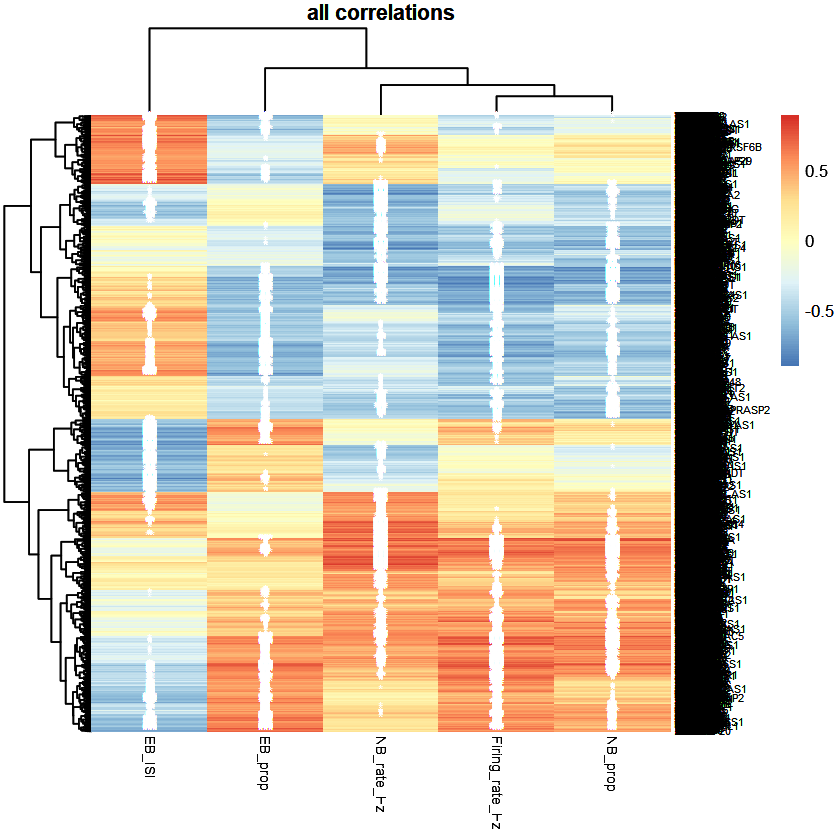

In [14]:
# Prepare matrices with gene names
corr_matrix <- module.trait.corr[significant_modules_corr_m_id, ]
pval_matrix <- module.trait.corr.pvals[significant_modules_corr_m_id, ]

# Replace row names with gene names
rownames(corr_matrix) <- genes_ID$Genename[match(rownames(corr_matrix), genes_ID$Geneid)]
rownames(pval_matrix) <- genes_ID$Genename[match(rownames(pval_matrix), genes_ID$Geneid)]

# Create asterisk matrix
asterisk_matrix <- matrix("", nrow = nrow(pval_matrix), ncol = ncol(pval_matrix))
asterisk_matrix[pval_matrix < 0.05] <- "*"
asterisk_matrix[pval_matrix < 0.01] <- "**"
asterisk_matrix[pval_matrix < 0.001] <- "***"

# Create heatmap
p<-pheatmap(corr_matrix,
         display_numbers = asterisk_matrix,
         number_color = "white",
         fontsize_number = 8,
         fontsize_row = 6,      # Gene name font size
         fontsize_col = 8,      # Trait name font size
         show_rownames = TRUE,
         main = "all correlations")
p
ggsave("headmap_all_correlations.pdf",
       width= 4,
       height = 8,
       plot=p)

In [ ]:
#GSEA based on ranked corr

In [15]:
"CLCN4" %in% significant_modules_corr_m

[1] TRUE

In [23]:
#combine scaled gene expresison with the activity variabes per sample and plot
#str(norm_counts_num)

In [30]:
head(samples_info)

,raw_annotation,sample,project,cell_line,group,condition,treatment,MEA,own_control,order
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,IPSI123-NT-09-E5_HumanL_deduplicated.bam,IPSI123_NT_E5,PUV11522,C4,C4_NT,control,NT,129-7009,NA,C1-NT
2,IPSI123-NT-09-F5_HumanL_deduplicated.bam,IPSI123_NT_F5,PUV11522,C4,C4_NT,control,NT,129-7009,NA,C4-NT
3,IPSI123-NT-10-A5_HumanL_deduplicated.bam,IPSI123_NT_A5,PUV11522,C4,C4_NT,control,NT,129-7010,NA,KdVS1-NT
4,IPSI123-NT-10-B5_HumanL_deduplicated.bam,IPSI123_NT_B5,PUV11522,C4,C4_NT,control,NT,129-7010,NA,KdVS1-F
5,KdVS1-F-09-A6_HumanL_deduplicated.bam,KdVS1_F_A6,PUV11522,KdVS1,KdVS1_F,KdVS,F,129-7009,KdVS1-NT,KdVS2-NT
6,KdVS1-F-09-B6_HumanL_deduplicated.bam,KdVS1_F_B6,PUV11522,KdVS1,KdVS1_F,KdVS,F,129-7009,KdVS1-NT,KdVS2-PH


In [32]:
clcn4<-norm_counts_num[ , "ENSG00000073464", drop = FALSE]
clcn4<-merge(MEA_seq, clcn4, by=0, all.x=TRUE)
clcn4$sample<-clcn4$Row.names
clcn4<- left_join(clcn4,samples_info, by="sample")#left join
head(clcn4)

,Row.names,Firing_rate_Hz,EB_prop,EB_ISI,NB_prop,NB_rate_Hz,ENSG00000073464,sample,raw_annotation,project,cell_line,group,condition,treatment,MEA,own_control,order
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<I<chr>>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,IPSI123_NT_A5,1.2059375,40.41281,0.02410064,0.8641783,0.06666667,7.632335,IPSI123_NT_A5,IPSI123-NT-10-A5_HumanL_deduplicated.bam,PUV11522,C4,C4_NT,control,NT,129-7010,NA,KdVS1-NT
2,IPSI123_NT_B5,1.2563333,39.92053,0.02240737,0.8495575,0.06666667,7.603650,IPSI123_NT_B5,IPSI123-NT-10-B5_HumanL_deduplicated.bam,PUV11522,C4,C4_NT,control,NT,129-7010,NA,KdVS1-F
3,IPSI123_NT_E5,1.7618750,38.61756,0.02407315,0.8071733,0.07000000,7.729869,IPSI123_NT_E5,IPSI123-NT-09-E5_HumanL_deduplicated.bam,PUV11522,C4,C4_NT,control,NT,129-7009,NA,C1-NT
4,IPSI123_NT_F5,2.1031875,46.70344,0.02217099,0.8098494,0.07000000,7.641300,IPSI123_NT_F5,IPSI123-NT-09-F5_HumanL_deduplicated.bam,PUV11522,C4,C4_NT,control,NT,129-7009,NA,C4-NT
5,KdVS1_F_A6,1.1693125,63.67488,0.01533676,0.6899446,0.01666667,8.077592,KdVS1_F_A6,KdVS1-F-09-A6_HumanL_deduplicated.bam,PUV11522,KdVS1,KdVS1_F,KdVS,F,129-7009,KdVS1-NT,KdVS2-NT
6,KdVS1_F_B6,0.8890625,37.41294,0.01831988,0.4210279,0.01333333,7.996992,KdVS1_F_B6,KdVS1-F-09-B6_HumanL_deduplicated.bam,PUV11522,KdVS1,KdVS1_F,KdVS,F,129-7009,KdVS1-NT,KdVS2-PH


In [41]:
color_vector <- c('control'='#555555','KdVS'='#9D1B1F')

In [48]:
p<-ggplot(clcn4, aes(
  x = NB_rate_Hz,
  y = ENSG00000073464,
  color = condition,     # color by condition
  shape = treatment,     # shape by treatment
  label = Row.names
)) +
  geom_point(size = 3) +
  geom_text_repel(aes(label = cell_line), size = 3, show.legend = FALSE) +  scale_color_manual(values = color_vector) +
  labs(
    x = "NB_rate_Hz",
    y = "CLCN4 expression",
    title = "NB_rate_Hz vs CLCN4",
    color = "Condition",
    shape = "Treatment"
  ) +
  theme_minimal()
ggsave("CLCN4_NB_rate.pdf",
       width= 6,
       height = 5,
       plot=p)

In [28]:
module.trait.corr.pvals_m[module.trait.corr.pvals_m$Genename == "CLCN4",]

,Geneid,trait,pvalue,Genename
,<fct>,<fct>,<dbl>,<chr>
6104,ENSG00000073464,Firing_rate_Hz,0.02,CLCN4
20584,ENSG00000073464,EB_prop,0.58,CLCN4
35064,ENSG00000073464,EB_ISI,0.14,CLCN4
49544,ENSG00000073464,NB_prop,0.04,CLCN4
64024,ENSG00000073464,NB_rate_Hz,0.00,CLCN4


In [ ]:
head(module.trait.corr.pvals_m)

In [ ]:
head(module.trait.corr_m)

In [15]:
#check 1 CLCN4 antcorrelated, but not differentiallye xpressed. Plot this
#check for mitochondrial genes, again enriched or not? GSEA
merged_df <- module.trait.corr_m %>%
  inner_join(module.trait.corr.pvals_m, 
             by = c("Geneid", "trait", "Genename"))
head(merged_df)

,Geneid,trait,corr,Genename,pvalue
,<fct>,<fct>,<dbl>,<chr>,<dbl>
1,ENSG00000160072,Firing_rate_Hz,0.09214929,ATAD3B,0.69
2,ENSG00000225630,Firing_rate_Hz,-0.40437580,MTND2P28,0.04
3,ENSG00000131584,Firing_rate_Hz,-0.28777349,ACAP3,0.16
4,ENSG00000169972,Firing_rate_Hz,0.63783784,PUSL1,0.00
5,ENSG00000157911,Firing_rate_Hz,0.52329472,PEX10,0.00
6,ENSG00000269896,Firing_rate_Hz,-0.52586873,,0.00


In [16]:
merged_sig <- merged_df %>%
  dplyr::filter(pvalue < 0.05)


In [17]:
# 3. Now, prepare ranked gene lists per trait
# fgsea needs a named numeric vector: names = gene IDs, values = ranking metric
ranked_lists <- merged_sig %>%
  group_split(trait) %>%
  setNames(unique(merged_sig$trait)) %>%
  lapply(function(x) {
    r <- x$corr
    names(r) <- x$Genename   # or Geneid if you prefer
    sort(r, decreasing = TRUE)
  })

In [18]:
# 1. Read the GMT file
gmt_path <- ".../0.Data/RNA_seq/counts_drugs_axion/gprofiler_full_hsapiens.name.gmt"
pathways <- gmtPathways(gmt_path)

In [19]:
# Summarize by prefix
table(sub("[:].*", "", names(pathways)))


CORUM    GO    HP   HPA MIRNA  REAC    WP 
 2885 22796 10668   830  2658  2532   790 

In [20]:
pathways_go_bp <- pathways[grep("^GO:BP", names(pathways))]
pathways_go_mf <- pathways[grep("^GO:MF", names(pathways))]
pathways_go_cc <- pathways[grep("^GO:CC", names(pathways))]
pathways_corum <- pathways[grep("^CORUM", names(pathways))]
pathways_hp    <- pathways[grep("^HP", names(pathways))]
pathways_hpa   <- pathways[grep("^HPA", names(pathways))]
pathways_mirna <- pathways[grep("^MIRNA", names(pathways))]
pathways_reac  <- pathways[grep("^REAC", names(pathways))]
pathways_wp    <- pathways[grep("^WP", names(pathways))]


In [21]:
pathways_selected <- c(pathways_go_bp, pathways_go_mf, pathways_go_cc, pathways_wp,pathways_reac)
str(pathways_selected)


List of 3322
 $ WP:000000         : chr [1:8133] "DPM1" "FGR" "CFH" "GCLC" ...
 $ WP:WP100          : chr [1:19] "GCLC" "GCLM" "GSTT2" "GGT5" ...
 $ WP:WP106          : chr [1:12] "ASPA" "DARS1" "GOT1" "GOT2" ...
 $ WP:WP107          : chr [1:50] "EIF2AK2" "EIF4B" "PABPC1" "EIF2B3" ...
 $ WP:WP111          : chr [1:103] "NDUFAB1" "SLC25A5" "UQCRC1" "COX15" ...
 $ WP:WP117          : chr [1:93] "CELSR3" "ADGRF5" "DRD4" "CELSR1" ...
 $ WP:WP12           : chr [1:16] "SLC9A1" "PDGFB" "ACP5" "AIMP2" ...
 $ WP:WP127          : chr [1:40] "BTK" "GSK3B" "IL5RA" "JAK2" ...
 $ WP:WP129          : chr [1:30] "MMP25" "TIMP2" "MMP2" "MMP11" ...
 $ WP:WP134          : chr [1:7] "PGLS" "PGD" "RPIA" "G6PD" ...
 $ WP:WP136          : chr [1:8] "PON1" "PON3" "PON2" "LIPA" ...
 $ WP:WP138          : chr [1:89] "FKBP4" "KDM1A" "CREBBP" "BRCA1" ...
 $ WP:WP1403         : chr [1:67] "CAMKK1" "ADIPOR2" "PIK3CB" "ELAVL1" ...
 $ WP:WP1422         : chr [1:30] "SPHK2" "PLPP1" "GBA2" "SPTLC1" ...
 $ WP:WP1423  

In [22]:
ranked_lists_unique <- lapply(ranked_lists, function(r) {
  tapply(r, names(r), mean)  # average if duplicate
})


In [23]:
fgsea_results <- lapply(names(ranked_lists), function(tr) {
  fgsea(pathways = pathways_selected,
        stats    = ranked_lists[[tr]],
        minSize  = 15,
        maxSize  = 500)
})
names(fgsea_results) <- names(ranked_lists)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (57.37% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (57.34% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (57.4% of the list).
The order of those tied genes will be arbit

In [24]:
sig_fgsea <- lapply(fgsea_results, function(df) {
  df %>% dplyr::filter(padj < 0.05)
})


In [25]:
sig_all <- bind_rows(
  lapply(names(sig_fgsea), function(tr) {
    sig_fgsea[[tr]] %>% mutate(trait = tr)
  })
)

head(sig_all)


pathway,pval,padj,log2err,ES,NES,size,leadingEdge,trait
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<chr>
REAC:R-HSA-109582,2.613302e-03,0.0234916205,0.4317077,0.1673014,1.892065,176,"GUCY1B1,....",Firing_rate_Hz
REAC:R-HSA-112310,1.245778e-04,0.0019286491,0.5188481,0.4948064,2.443854,19,"GAD1, LI....",Firing_rate_Hz
REAC:R-HSA-112314,4.890613e-04,0.0063883626,0.4772708,0.2576158,2.232021,77,"KCNJ3, T....",Firing_rate_Hz
REAC:R-HSA-112315,1.036535e-05,0.0001969416,0.5933255,0.2741107,2.619136,101,"KCNJ3, T....",Firing_rate_Hz
REAC:R-HSA-112316,1.742089e-05,0.0003236414,0.5756103,0.2274780,2.463250,157,"KCNJ3, S....",Firing_rate_Hz
REAC:R-HSA-114608,2.265075e-05,0.0004116528,0.5756103,0.4163088,2.687284,37,"TIMP3, T....",Firing_rate_Hz


In [26]:
# 1. Read the GMT file
 
# Read GMT
gprofiler_gmt <- read.delim(".../0.Data/RNA_seq/counts_drugs_axion/gprofiler_full_hsapiens.name.gmt", 
                            header = FALSE, sep = "\t", stringsAsFactors = FALSE)

In [27]:
# Keep only first two columns for ID and name
gmt_subset <- gprofiler_gmt %>%
  dplyr::select(V1, V2) %>%
  dplyr::rename(external_id = V1,
                pathway_name = V2)

# Optional: create a list-column of genes
genes_list <- gprofiler_gmt %>%
  dplyr::select(-V1, -V2) %>%               
  apply(1, function(x) x[x != ""])   # remove empty strings

# Add to subset
gmt_subset$genes <- genes_list

In [28]:
head(sig_all)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,trait
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<chr>
REAC:R-HSA-109582,2.613302e-03,0.0234916205,0.4317077,0.1673014,1.892065,176,"GUCY1B1,....",Firing_rate_Hz
REAC:R-HSA-112310,1.245778e-04,0.0019286491,0.5188481,0.4948064,2.443854,19,"GAD1, LI....",Firing_rate_Hz
REAC:R-HSA-112314,4.890613e-04,0.0063883626,0.4772708,0.2576158,2.232021,77,"KCNJ3, T....",Firing_rate_Hz
REAC:R-HSA-112315,1.036535e-05,0.0001969416,0.5933255,0.2741107,2.619136,101,"KCNJ3, T....",Firing_rate_Hz
REAC:R-HSA-112316,1.742089e-05,0.0003236414,0.5756103,0.2274780,2.463250,157,"KCNJ3, S....",Firing_rate_Hz
REAC:R-HSA-114608,2.265075e-05,0.0004116528,0.5756103,0.4163088,2.687284,37,"TIMP3, T....",Firing_rate_Hz


In [29]:
head(gmt_subset)

,external_id,pathway_name,genes
,<chr>,<chr>,<list>
1,CORUM:0000000,CORUM root,"DPM1, GC...."
2,CORUM:1,BCL6-HDAC4 complex,"HDAC4, BCL6"
3,CORUM:10,Condensin I complex,"NCAPD2, ...."
4,CORUM:100,hNURF complex,"RBBP7, R...."
5,CORUM:1000,TorsinA-TorsinB complex,"TOR1B, TOR1A"
6,CORUM:1003,RC complex (Replication competent complex),"POLA2, R...."


In [30]:
sig_all_named<-sig_all  %>%
  left_join(gmt_subset, by = c("pathway" = "external_id"))

In [31]:
head(sig_all_named)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,trait,pathway_name,genes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<chr>,<chr>,<list>
REAC:R-HSA-109582,2.613302e-03,0.0234916205,0.4317077,0.1673014,1.892065,176,"GUCY1B1,....",Firing_rate_Hz,Hemostasis,"FGR, CD9...."
REAC:R-HSA-112310,1.245778e-04,0.0019286491,0.5188481,0.4948064,2.443854,19,"GAD1, LI....",Firing_rate_Hz,Neurotransmitter release cycle,"TSPOAP1,...."
REAC:R-HSA-112314,4.890613e-04,0.0063883626,0.4772708,0.2576158,2.232021,77,"KCNJ3, T....",Firing_rate_Hz,Neurotransmitter receptors and postsynaptic signal transmission,"CAMKK1, ...."
REAC:R-HSA-112315,1.036535e-05,0.0001969416,0.5933255,0.2741107,2.619136,101,"KCNJ3, T....",Firing_rate_Hz,Transmission across Chemical Synapses,"CAMKK1, ...."
REAC:R-HSA-112316,1.742089e-05,0.0003236414,0.5756103,0.2274780,2.463250,157,"KCNJ3, S....",Firing_rate_Hz,Neuronal System,"CAMKK1, ...."
REAC:R-HSA-114608,2.265075e-05,0.0004116528,0.5756103,0.4163088,2.687284,37,"TIMP3, T....",Firing_rate_Hz,Platelet degranulation,"LAMP2, I...."


In [34]:
# Filter pathways containing "mitochondria" (case-insensitive)
neuron_projection_pathways <- sig_all_named %>%
  dplyr::filter(grepl("neuron", pathway_name, ignore.case = TRUE))
neuron_projection_pathways

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,trait,pathway_name,genes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<chr>,<chr>,<list>
REAC:R-HSA-112316,1.742089e-05,3.236414e-04,0.5756103,0.2274780,2.463250,157,"KCNJ3, S....",Firing_rate_Hz,Neuronal System,"CAMKK1, ...."
REAC:R-HSA-112316,2.935402e-19,7.726398e-18,1.1330899,0.4285099,4.745021,137,"GABRA2, ....",EB_prop,Neuronal System,"CAMKK1, ...."
WP:WP4222,1.850685e-03,1.175823e-02,0.4550599,0.4777711,2.153567,15,"ADCY2, C....",EB_prop,Phosphodiesterases in neuronal function,"GUCY1B1,...."
REAC:R-HSA-112316,3.480644e-16,2.822803e-13,1.0376962,-0.3762692,-4.142833,158,"PRKCB, N....",EB_ISI,Neuronal System,"CAMKK1, ...."
REAC:R-HSA-112316,1.008445e-02,4.581848e-02,0.3807304,0.1616748,1.791979,147,"TUBA4A, ....",NB_prop,Neuronal System,"CAMKK1, ...."


In [63]:

# Filter pathways containing "mitochondria" (case-insensitive)
mito_pathways <- sig_all_named %>%
  dplyr::filter(grepl("mitochondria", pathway_name, ignore.case = TRUE))

# View results
mito_pathways

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,trait,pathway_name,genes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<chr>,<chr>,<list>
REAC:R-HSA-5368286,1.285323e-03,1.343163e-02,0.4550599,0.4034862,2.141614,24,"MRPL19, ....",Firing_rate_Hz,Mitochondrial translation initiation,"MRPS10, ...."
REAC:R-HSA-5368287,3.301544e-04,4.381097e-03,0.4984931,0.4170227,2.381472,27,"MRPL19, ....",Firing_rate_Hz,Mitochondrial translation,"MRPS10, ...."
REAC:R-HSA-5389840,1.166351e-03,1.250089e-02,0.4550599,0.4062523,2.206064,25,"MRPL19, ....",Firing_rate_Hz,Mitochondrial translation elongation,"MRPS10, ...."
REAC:R-HSA-5419276,1.231395e-03,1.303096e-02,0.4550599,0.4040951,2.144846,24,"MRPL19, ....",Firing_rate_Hz,Mitochondrial translation termination,"MRPS10, ...."
WP:WP111,5.509671e-05,1.080674e-03,0.5573322,0.4097858,2.644075,35,"UQCRC1, ....",EB_ISI,Electron transport chain: OXPHOS system in mitochondria,"NDUFAB1,...."
WP:WP4324,4.819146e-03,3.722216e-02,0.4070179,0.4106987,2.082087,19,"DMAC2, E....",EB_ISI,Mitochondrial complex I assembly model OXPHOS system,"NDUFAF7,...."
REAC:R-HSA-5368287,4.591474e-03,2.476434e-02,0.4070179,0.3128406,1.936162,33,"MRPS9, M....",NB_prop,Mitochondrial translation,"MRPS10, ...."
REAC:R-HSA-5389840,4.487994e-03,2.436340e-02,0.4070179,0.3364894,1.993455,30,"MRPS9, M....",NB_prop,Mitochondrial translation elongation,"MRPS10, ...."
REAC:R-HSA-5419276,1.123421e-02,4.816310e-02,0.3807304,0.3268793,1.890554,28,"MRPS9, M....",NB_prop,Mitochondrial translation termination,"MRPS10, ...."


In [ ]:
mito_pathways

In [64]:
df_plot <- mito_pathways %>%
  mutate(logFDR = -log10(padj))  # useful for coloring

In [68]:
p<-ggplot(df_plot, aes(x = NES, 
                    y = pathway_name,
                    size = size,
                    color = logFDR)) +
  geom_point(alpha = 0.8) +
  scale_size_continuous(range = c(3,10)) +
  scale_color_gradient(low = "skyblue", high = "red") +
  facet_wrap(~trait, scales = "free_y") +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.y = element_text(size = 8),
    strip.text = element_text(face = "bold"),
    panel.grid.major.y = element_blank()
  ) +
  labs(
    x = "Normalized Enrichment Score (NES)",
    y = "Mitochondrial pathway",
    size = "Pathway size",
    color = "-log10(FDR)",
    title = "Enriched Pathways per Trait"
  )

ggsave("mitochondria_MEAseq.pdf",
       width= 10,
       height = 7,
       plot=p)